In [1]:
import os
import sys

sys.path.append('..')

In [19]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
%matplotlib inline

In [4]:
DATA_ROOT = '../preprocess/data'
print(os.path.exists(DATA_ROOT))

True


In [161]:
mask_fn = 'cropped_aachen_000000_000019_labelIds.png'  # cropped
mask_fn = 'aachen_000000_000019_gtFine_labelIds.png'
mask_path = os.path.join(DATA_ROOT, mask_fn)
print(os.path.exists(mask_path))

True


In [9]:
mask_img = Image.open(mask_path)
mask = np.array(mask_img)

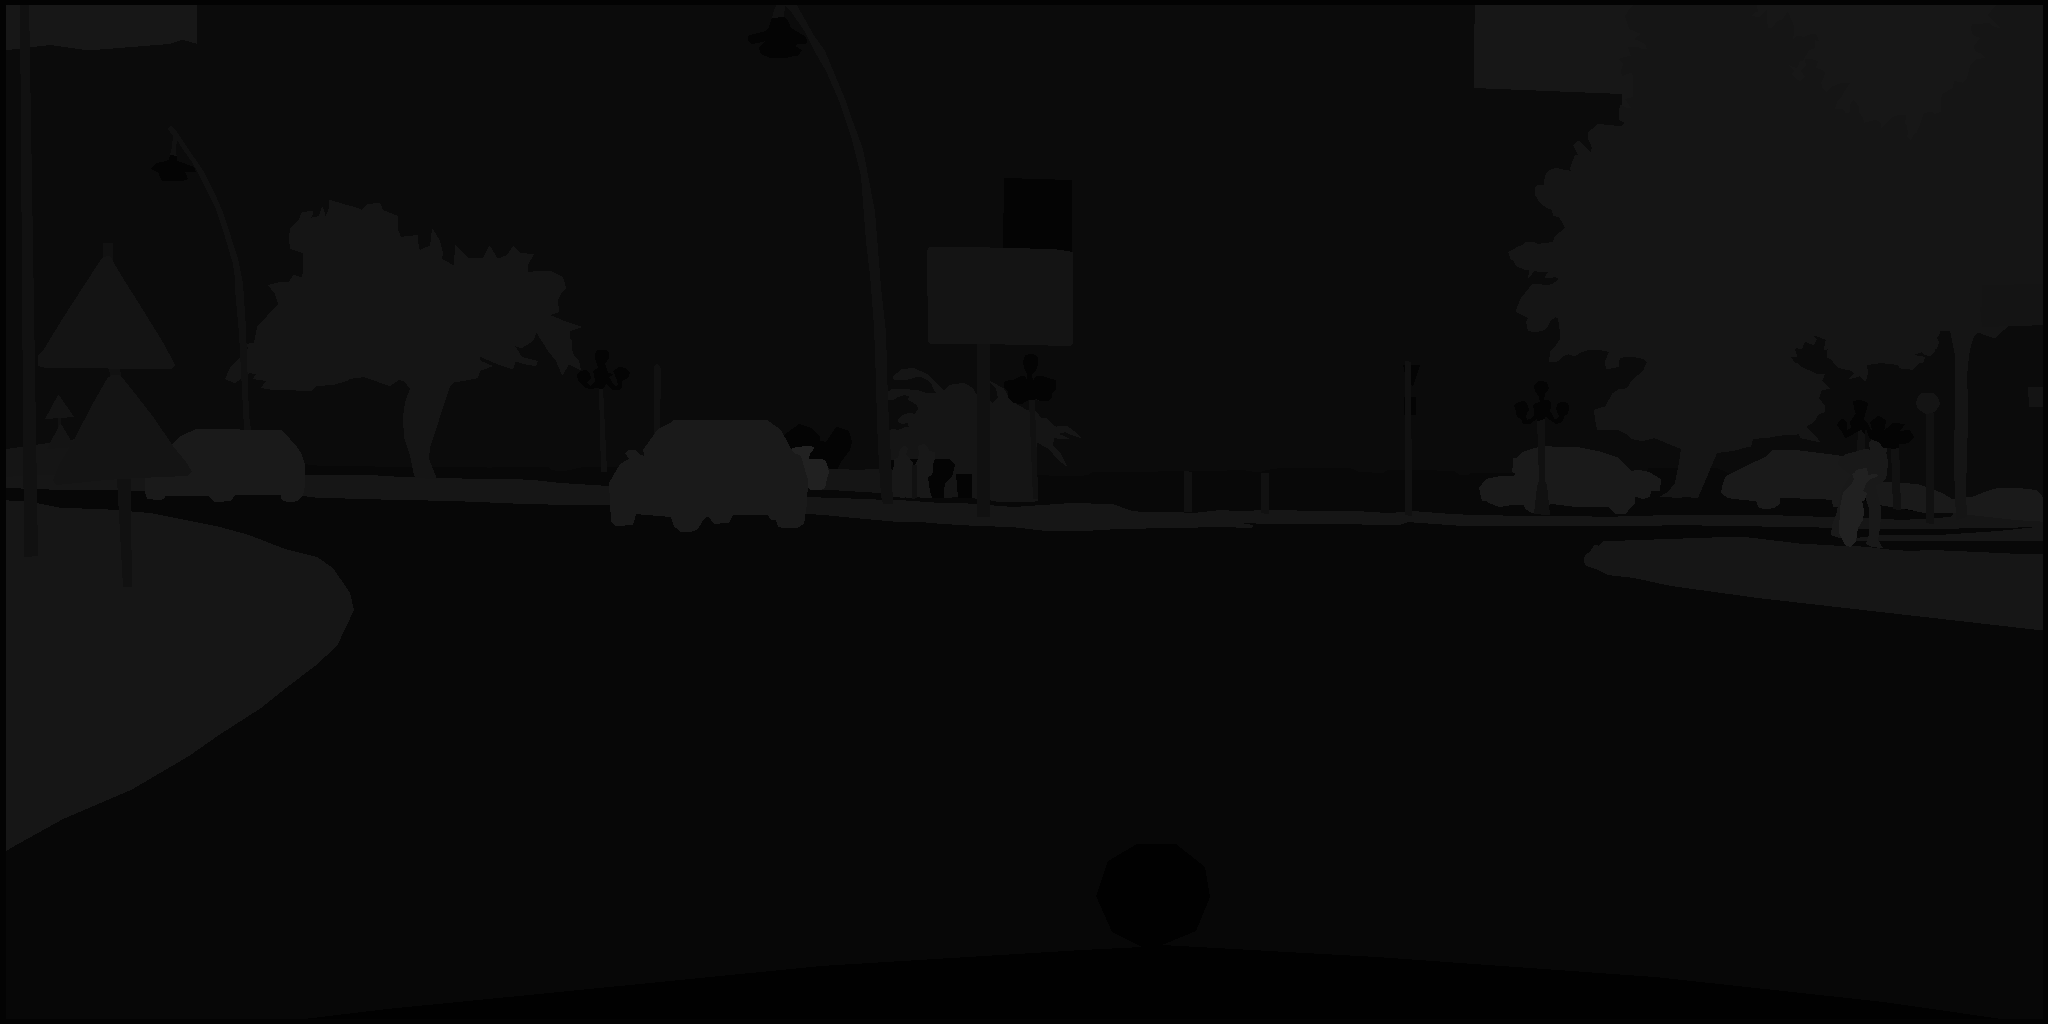

In [10]:
display(mask_img)

figure out the interal function for `seg2edge` 

In [148]:
radius = 2
ignore_label = [2, 3]
edge_type = "regular"

In [149]:
h, w = mask.shape
print(mask.shape)

(1024, 2048)


In [150]:
search_radius = int(max(math.ceil(radius), 1))
print(search_radius)

2


In [151]:
_x = np.linspace(0, w - 1, w, dtype=np.int64)
_y = np.linspace(0, h - 1, h, dtype=np.int64)
_rx = np.linspace(-search_radius, search_radius, search_radius * 2 + 1, dtype=np.int64)
_ry = np.linspace(-search_radius, search_radius, search_radius * 2 + 1, dtype=np.int64)

In [152]:
X, Y = np.meshgrid(_x, _y)
rx, ry = np.meshgrid(_rx, _ry)

In [153]:
X = X.flatten()
Y = Y.flatten()
rx = rx.flatten()
ry = ry.flatten()

In [154]:
neighbor_idxs = np.sqrt(rx**2 + ry**2) <= radius
rx = rx[neighbor_idxs]
ry = ry[neighbor_idxs]

In [155]:
num_img_px = len(X)
print(len(X))

2097152


In [191]:
# initialize array
edge_idx = np.zeros(num_img_px, dtype=bool)

# loop radius
for x, y in zip(rx, ry):
    print(x, y)
    
    X_neighbor = X + x
    Y_neighbor = Y + y
    valid_idx = np.where(
        (X_neighbor >= 0)
        & (X_neighbor < w)
        & (Y_neighbor >= 0)
        & (Y_neighbor < h)
    )[0]  # NOTE: it's a tuple...
    
    # print(type(valid_idx))
    # print(valid_idx)
    # print(valid_idx.shape)
    
    X_center = X[valid_idx]
    Y_center = Y[valid_idx]
    X_neighbor = X_neighbor[valid_idx]
    Y_neighbor = Y_neighbor[valid_idx]
    L_center = mask[Y_center, X_center]
    L_neighbor = mask[Y_neighbor, X_neighbor]
    # print(L_center)
    # print(L_center.shape)
    
    
    # FIXME: what are 'inner' and 'outer'?
    if edge_type == "regular":
        # print(edge_type)
        
        diff_idx = np.where(L_center != L_neighbor)[0]
        # print(type(diff_idx))
        # print(diff_idx)
        # print(diff_idx.shape)
    elif edge_type == "inner":
        # print(edge_type)
        
#         print((L_center != 0).all())
#         print((L_neighbor == 0).any())
        
        diff_idx = np.where(
            (L_center != L_neighbor)
            & (L_center != 0)  # FIXME: what? why 0?
            & (L_neighbor == 0)
        )[0]
        # print(diff_idx)
        # print(diff_idx.shape)
    elif edge_type == "outer":
        # print(edge_type)
        
        diff_idx = np.where(
            (L_center != L_neighbor)
            & (L_center == 0)
            & (L_neighbor != 0)
        )[0]
        # print(diff_idx)
        # print(diff_idx.shape)
    else:
        raise ValueError()
        
    L_center_edge = L_center[diff_idx]
    L_neighbor_edge = L_neighbor[diff_idx]
    use_idx = np.ones(diff_idx.shape, dtype=bool)
    
    assert L_center_edge.shape == L_neighbor_edge.shape == use_idx.shape
    
    for label in ignore_label:
        ignore_idx = np.where((L_center_edge == label) | (L_neighbor_edge == label))
        use_idx[ignore_idx] = False
        
    assert use_idx.shape == L_center_edge.shape == L_neighbor_edge.shape
    
    # print(use_idx)
    # print(use_idx.all())
    
    diff_gt_idx = diff_idx[use_idx]
    
    edge_idx[valid_idx[diff_gt_idx]] = True
    
    # print(diff_gt_idx)
    
    # break for now
    # break

print(edge_idx.shape)
print(edge_idx.any())

edges = edge_idx.reshape(h, w)

0 -2
-1 -1
0 -1
1 -1
-2 0
-1 0
0 0
1 0
2 0
-1 1
0 1
1 1
0 2
(2097152,)
True


In [192]:
edge_img = edges.astype('uint8')

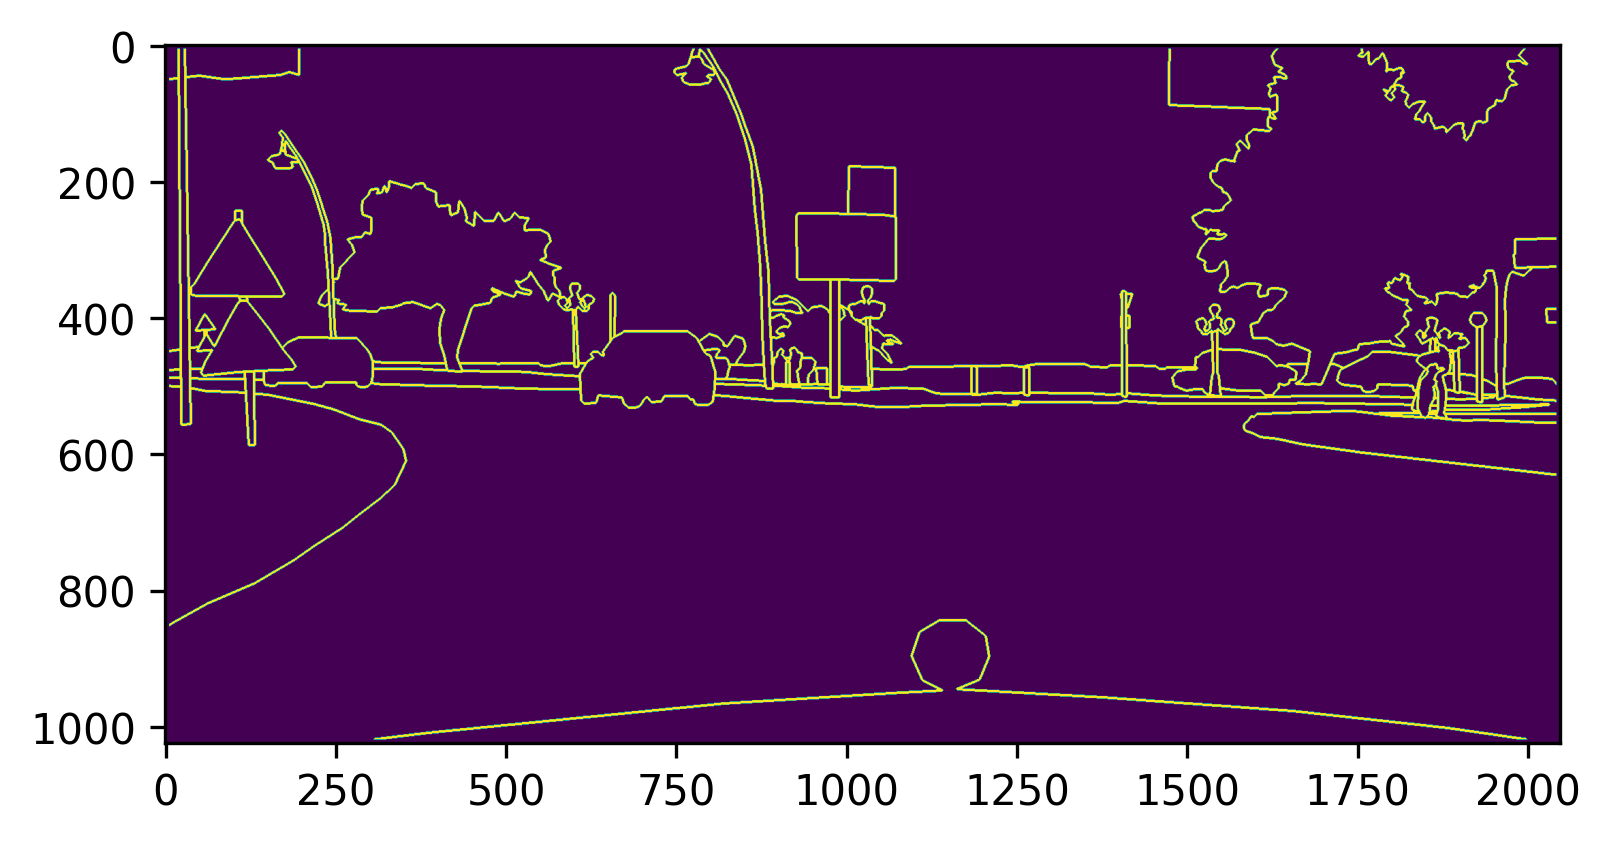

In [193]:
plt.imshow(edges)
plt.gcf().set_dpi(300)

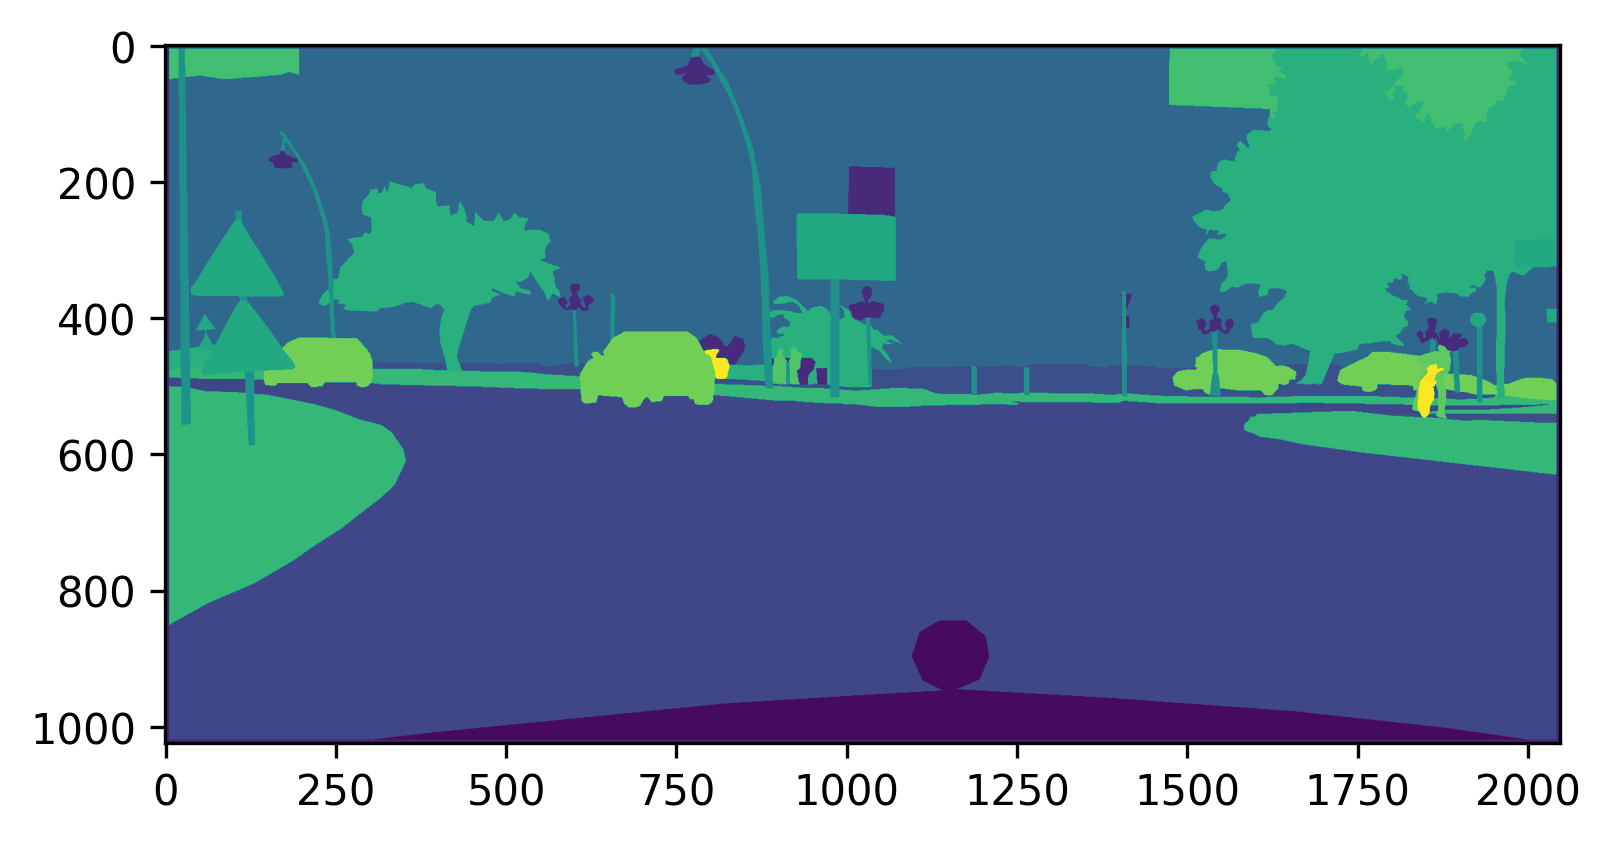

In [179]:
plt.imshow(mask)
plt.gcf().set_dpi(300)